In [1]:
%config Completer.use_jedi = False
# !pip install spacy 
import spacy
import torch
import pandas as pd

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_df=pd.read_csv("../Takwimu Lab - Machine Translation Challenge/dataset/Train.csv")
train_df.head(10)

,ID,French,Target_Language,Target
0,ID_AADNDxdl,Mon père,Fon,Tɔ ce
1,ID_AAFQhmDr,Mettez-vous en rang.,Fon,Mi tò miɖéé
2,ID_AAHVDMdq,"Sénégal, Côte d'Ivoire, Guinée, Ghana, on déco...",Ewe,"Sénégal, Côte d'Ivoire, Guinée, Ghana, siwo ƒe..."
3,ID_AAJfVHEH,Son doigt lui fait mal.,Fon,Alɔvi tɔn ɖo vivɛ wɛ
4,ID_AAOJuhzN,La pluie a commencé.,Fon,Jì bɛ́
5,ID_AAOZhyDe,Les garçons et les filles sont au cours élémen...,Fon,Nyɔnu lε kpo sunnu lε kpo ɖo wemaxomε ayi jε t...
6,ID_AARXSjjg,Janot se prit à grelotter dès que le soleil se...,Ewe,Yano dze ƒoƒo esi me ɣe gbe ɖo to eye ya dze ƒ...
7,ID_AATzGMBp,Je me rappelle l'avoir acheté ici,Fon,Un flin ɖɔ un xɔ ɖo fi.
8,ID_AAUnHmrE,"Il l’a fait, bien sûr.",Fon,E bló hŭn
9,ID_AAesDOKn,Mets l’enfant sur ton dos.,Fon,Kpan vì ɔ̀ dó nɛ̀gbé


In [4]:

fr = spacy.load('fr')

In [5]:
def tokenize_fr(sentence):
    return [tok.text for tok in fr.tokenizer(sentence)]


In [6]:
# train_df['french_tokens']=train_df['French'].astype(str).apply(tokenize_fr)
# train_df['french_tokens']

In [18]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
# train_df['French'][0],train_df['Target'][0]

In [19]:
train_df['fr_fon_pairs']=list(zip(train_df['French'].astype(str).apply(normalizeString),train_df['Target'].apply(normalizeString)))
train_df['fr_fon_pairs']

0                                         (mon pere, t ce)
1                     (mettez vous en rang ., mi to mi ee)
2        (senegal cote d ivoire guinee ghana on decouvr...
3           (son doigt lui fait mal ., al vi t n o viv w )
4                           (la pluie a commence ., ji b )
                               ...                        
75482                             (reconduis le ., kpl yi)
75483    (le vent pousse le nuage, j h n o akp kp sis w .)
75484    (si mon mari conduit c est que ce n est pas lo...
75485    (cette annee je vais epouser celle la ., xwe e...
75486    (dans une casserole je la fais fondre dans un ...
Name: fr_fon_pairs, Length: 75487, dtype: object

In [ ]:
# train_df['fr_fon_pairs']=train_df['fr_fon_pairs'].map(list)
# pairs=train_df['fr_fon_pairs'].tolist()
# pairs

In [20]:

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [21]:
# lines = open('../Takwimu Lab - Machine Translation Challenge/dataset/%s-%s.txt' % ('eng', 'fra'), encoding='utf-8').\
#         read().strip().split('\n')
# print(lines)
# pairs_1 = [[normalizeString(s) for s in l.split('\t')] for l in lines]
# print(pairs_1)

In [22]:
def readLangs(lang1, lang2, reverse=False):
    train_df['fr_fon_pairs']=train_df['fr_fon_pairs'].map(list)
    pairs=train_df['fr_fon_pairs'].tolist()  
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [23]:
MAX_LENGTH = 100

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [24]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     print(pairs[:2])
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
#     print('filter pairs',pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [25]:
input_lang, output_lang, pairs = prepareData('fra', 'fon', True)
# print(random.choice(pairs))

Read 75487 sentence pairs
Trimmed to 1 sentence pairs
Counting words...
Counted words:
fon 10
fra 11


In [193]:
random.choice(pairs)

['nyemenye adzredola o ta eko metr dzo kpoo',
 'i am not a trouble maker so i just left']

In [194]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

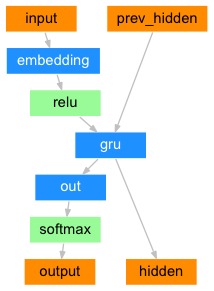

In [195]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [196]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [197]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [198]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [199]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [211]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [212]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [213]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [214]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [215]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 43s (- 38m 7s) (5000 6%) 0.0043
5m 17s (- 34m 24s) (10000 13%) 0.0000
7m 51s (- 31m 26s) (15000 20%) 0.0000
10m 24s (- 28m 37s) (20000 26%) 0.0000
12m 58s (- 25m 56s) (25000 33%) 0.0036
15m 32s (- 23m 19s) (30000 40%) 0.0000
18m 6s (- 20m 41s) (35000 46%) 0.0000
20m 40s (- 18m 5s) (40000 53%) 0.0000
23m 14s (- 15m 29s) (45000 60%) 0.0000
25m 48s (- 12m 54s) (50000 66%) 0.0000
28m 22s (- 10m 19s) (55000 73%) 0.0000
30m 56s (- 7m 44s) (60000 80%) 0.0000
33m 31s (- 5m 9s) (65000 86%) 0.0000
36m 6s (- 2m 34s) (70000 93%) 0.0000
38m 43s (- 0m 0s) (75000 100%) 0.0000
